In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
receiver_stat_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
]

team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
]
opp_stat_cols = [
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

x_cols = game_context_cols + [
    'air_td',
    'air_fd',
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
] + ['passing_yards_opp_roll']

In [3]:
passes = Quack.query(f"""
select pbp.game_id, pbp.air_yards,
	case when pbp.air_yards >= pbp.yardline_100 then 1 else 0 end as air_td,
	case when pbp.air_yards >= pbp.ydstogo then 1 else 0 end as air_fd,
	greatest(least(pbp.air_yards + 40, 139),1) as air_yards_shifted,
	pbp.first_down, pbp.touchdown,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	{Quack.select_columns(receiver_stat_cols, alias='r', coalesce=True)},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.receiver_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.pass = 1
	and pbp.pass_attempt = 1
	and pbp.down is not null
    and pbp.play_type = 'pass'
""")

X = passes[x_cols]
y = passes['air_yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
obs = len(X)
num_feats = len(x_cols)
y.shape

(211109,)

In [4]:
print(y.min(),y.max())

1.0 139.0


In [5]:
passes['air_td'].value_counts(normalize=True).reset_index().sort_values(by='air_td').head(20)

,air_td,proportion
0,0,0.932357
1,1,0.067643


In [6]:
class maskedModel(nn.Module):
	def __init__(self, n_in=11, n_out=140, n_hidden=512):
		super(maskedModel, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		#ResBlock(n_hidden),
		#ResBlock(n_hidden),
		#ResBlock(n_hidden),
		)
		self.output_layer  = nn.Linear(n_hidden, n_out)
		self.td_head = nn.Sequential(ResBlock(n_hidden), nn.Linear(n_hidden,1))
		
	def forward(self, x):
		logits=0 # need for weird cuda error?
		# Extract the feature to pass to the final layer (e.g., the first feature)
		yardline = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
		td_bin = (yardline + 40).long().squeeze(1)
		x = self.main_layers(x)
		td_logits = self.td_head(x)
		logits = self.output_layer(x)
		batch_indices = torch.arange(logits.size(0), device=logits.device)
		logits[batch_indices, td_bin] = logits[batch_indices, td_bin] + td_logits.squeeze(1)
		
		yard_values = torch.arange(-40, self.n_out - 40, device=x.device).float().unsqueeze(0)
		mask = (yard_values <= yardline).float()
		logits = logits + (mask - 1) * 1e3

		return logits

In [7]:
def adjacent_label_smoothing(labels, yardline, num_classes=130, smoothing=0.1, k=3):
    """
    labels: [batch]
    yardline: [batch]
    k: number of bins to smooth on each side
    """
    batch_size = labels.size(0)
    device = labels.device
    
    smoothed = torch.zeros(batch_size, num_classes, device=device)
    idx = torch.arange(batch_size, device=device)

    # total weight for neighbors
    neighbor_smoothing = smoothing / (2 * k)
    
    # main label
    smoothed[idx, labels] = 1.0 - smoothing

    # left and right neighbors
    for offset in range(1, k+1):
        # left
        left_idx = labels - offset
        valid_left = left_idx >= 0
        smoothed[idx[valid_left], left_idx[valid_left]] += neighbor_smoothing

        # right
        right_idx = labels + offset
        valid_right = right_idx < num_classes
        smoothed[idx[valid_right], right_idx[valid_right]] += neighbor_smoothing

        # edge correction
        smoothed[idx[~valid_left], labels[~valid_left]] += neighbor_smoothing
        smoothed[idx[~valid_right], labels[~valid_right]] += neighbor_smoothing

    # mask impossible yards
    mask = torch.arange(num_classes, device=device).expand(batch_size, -1) > (yardline + 30).unsqueeze(1)
    smoothed[mask] = 0

    return smoothed


In [ ]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1, k=22)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.008)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 10  # 10% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0
		yard_idx = torch.arange(n_out, device=device).unsqueeze(0)

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)

			fd_mask = yard_idx >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = yard_idx >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 0.1
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.25

			
			distance = yard_idx.unsqueeze(0) - pred_mean.unsqueeze(1)  # [batch, num_bins]

			penalty = (distance ** 2 * probs).sum(1).mean()  

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y_smooth) * 3
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) 
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [9]:
air_yards_model = train_model(X_tensor, y_tensor, num_feats, 140, n_hidden=128, epochs = 10, batch_size=2048) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')
#Test Loss: 3.6856, Test Accuracy: 0.0827
#Test Loss: 3.3504, Test Accuracy: 0.1119

cuda
tensors loading
splitting batches
tensor(0.4387, device='cuda:0')
tensor(0.0674, device='cuda:0')
Epoch 1/10, Classifier Loss: 17.8403, MSE Loss: 102.7468
Test Loss: 4.1322, Test Accuracy: 0.0798
Epoch 2/10, Classifier Loss: 11.3573, MSE Loss: 75.4946
Test Loss: 4.2640, Test Accuracy: 0.0631
Epoch 3/10, Classifier Loss: 11.8446, MSE Loss: 55.7046
Test Loss: 4.1252, Test Accuracy: 0.0640
Epoch 4/10, Classifier Loss: 11.2891, MSE Loss: 45.1171
Test Loss: 3.8417, Test Accuracy: 0.0768
Epoch 5/10, Classifier Loss: 10.8270, MSE Loss: 41.9671
Test Loss: 3.7071, Test Accuracy: 0.0838
Epoch 6/10, Classifier Loss: 10.4525, MSE Loss: 41.8740
Test Loss: 3.5481, Test Accuracy: 0.1019
Epoch 7/10, Classifier Loss: 10.1667, MSE Loss: 40.4826
Test Loss: 3.4595, Test Accuracy: 0.1076
Epoch 8/10, Classifier Loss: 9.9559, MSE Loss: 40.1717
Test Loss: 3.3923, Test Accuracy: 0.1114
Epoch 9/10, Classifier Loss: 9.8027, MSE Loss: 39.6563
Test Loss: 3.3509, Test Accuracy: 0.1147
Epoch 10/10, Classifier L

true_first=0.39, true_td=0.02
fd_model=0.42, td_model=0.00
[4.4715973e-10 1.4898354e-08 1.1441185e-09 1.6434220e-09 2.1794615e-09
 3.1332217e-09 2.2109731e-11 9.3629304e-10 3.8118407e-07 5.3650933e-08
 4.2417664e-06 2.6925009e-05 7.6836739e-05 1.1878724e-04 1.8833406e-04
 4.5122557e-05 2.9327656e-04 5.3174712e-04 5.1041541e-04 5.5209091e-03
 6.4363296e-04 7.2606513e-04 2.2726137e-02 3.2803722e-02 1.2996250e-03
 1.7419343e-03 1.1065900e-04 1.5885899e-03 1.7289041e-03 3.4445886e-06
 2.0731054e-03 1.5479468e-03 8.0366647e-03 6.2703630e-03 4.0987607e-02
 2.1305891e-02 2.3699742e-02 2.3998022e-02 2.3744695e-02 2.8660363e-02
 3.7281763e-02 3.6686938e-02 3.9757214e-02 4.7935911e-02 4.7441050e-02
 5.5548809e-02 3.5446245e-02 3.4622058e-02 1.9248083e-02 3.2758135e-02
 1.3810028e-02 1.9392304e-02 1.8613536e-02 1.4591313e-02 1.6675686e-02
 1.2821532e-02 7.4866712e-03 8.5371118e-03 9.2388904e-03 7.7704429e-03
 1.1898404e-02 1.1217233e-02 5.2499361e-03]
Actual mean: 9.03, Model mean: 8.99
number of

(-15.0, 78.0)

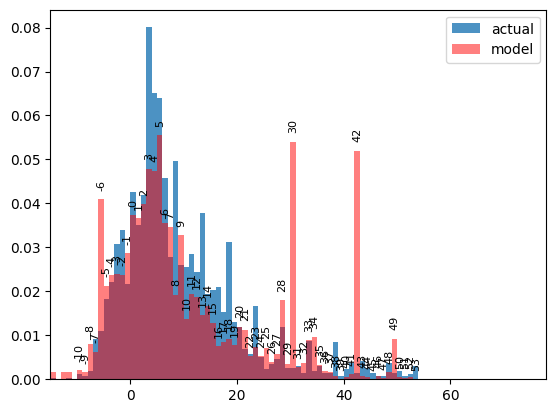

In [12]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = passes.loc[(passes.yardline_100.between(yard,yard)) & (passes.down.between(1,3))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['air_yards']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = air_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	print(probs[0:yard+10])

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 53
down = 3
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')

# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-15,yard+25)